# Plot results from syntetic resolution tests
computation is done with the .py script.
As in Makus et al., 2024

## 1. Load data

In [ ]:
proj_dir = '/path/to/your/project'

In [28]:
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime

freq0 = 1.0
corr_len = 2
std_model = 0.004

infile = glob.glob(
    os.path.join(
        proj_dir,
        f'spatial/synthetic_test_coarse_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}-{freq0*2}/dvdt_3D.npz')[0]


outfolder = os.path.join(os.path.dirname(os.path.dirname(infile)), 'figures')
os.makedirs(outfolder, exist_ok=True)

loaded = np.load(infile)

x = loaded['xaxis']
y = loaded['yaxis']
t = loaded['taxis']
dvdt = loaded['dv']
statx = loaded['statx']
staty = loaded['staty']
# No data anymore from this date on
start = 0  # 4 for february # Start here for February
start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
end = -1
# note that this are rows -> latitude, columns -> longitude, pages -> time
dvdt = dvdt[:,:,start:]
t = t[start:]

dv_total = dvdt[:, :, -1]
dv = np.nan_to_num(dvdt)
resolution = np.nan_to_num(loaded['resolution'])

utcs = [UTCDateTime(tt) for tt in t]
datetimes = [utci.datetime for utci in utcs]


In [29]:
from obspy.geodetics import degrees2kilometers, locations2degrees
from seismic.monitor.spatial import geo2cart

lat = [46.05, 46.36]
lon = [-122.45, -122.03]



# Y-extent
y2 = degrees2kilometers(lat[1]- lat[0])

# X-Extent
x2 = degrees2kilometers(locations2degrees(lat[0], lon[0], lat[0], lon[1]))
chkb2 = np.zeros((int(y2+1)+1, int(x2+1)+1))
for ii, yy in enumerate(np.arange(y2+1)):
    chkb2[ii, :] = np.sin(
        4*np.pi*np.arange(x2/1+1)/(x2/1)+2.5) + np.cos(4*np.pi*yy/(y2))


# also plot MSH
MSH = [46.19113335236592, -122.19448731767436]
msh_x, msh_y = geo2cart(MSH[0], MSH[1], lat[0], lon[0])

In [30]:
if 'vert' in infile:
    chkb2 = np.ones(dv[..., -1].shape)
    chkb2[:chkb2.shape[0]//2] *= -1
elif 'horiz' in infile:
    chkb2 = np.ones(dv[..., -1].shape)
    chkb2[:, :chkb2.shape[-1]//2] *= -1
elif 'const' in infile:
    chkb2 = np.ones(dv[..., -1].shape)
elif 'coarse' in infile:
    chkb2 = np.zeros((int(y2+1)+1, int(x2+1)+1))
    for ii, yy in enumerate(np.arange(y2+1)):
        chkb2[ii, :] = np.sin(
            2*np.pi*np.arange(x2/1+1)/(x2/1)+4.5) + np.cos(2*np.pi*yy/(y2))
elif 'fine' in infile:
    chkb2 = np.zeros((int(y2+1)+1, int(x2+1)+1))
    for ii, yy in enumerate(np.arange(y2+1)):
        chkb2[ii, :] = np.sin(
            8*np.pi*np.arange(x2/1+1)/(x2/1)) + np.cos(8*np.pi*yy/(y2)+1.5)
chkb2 *= -1

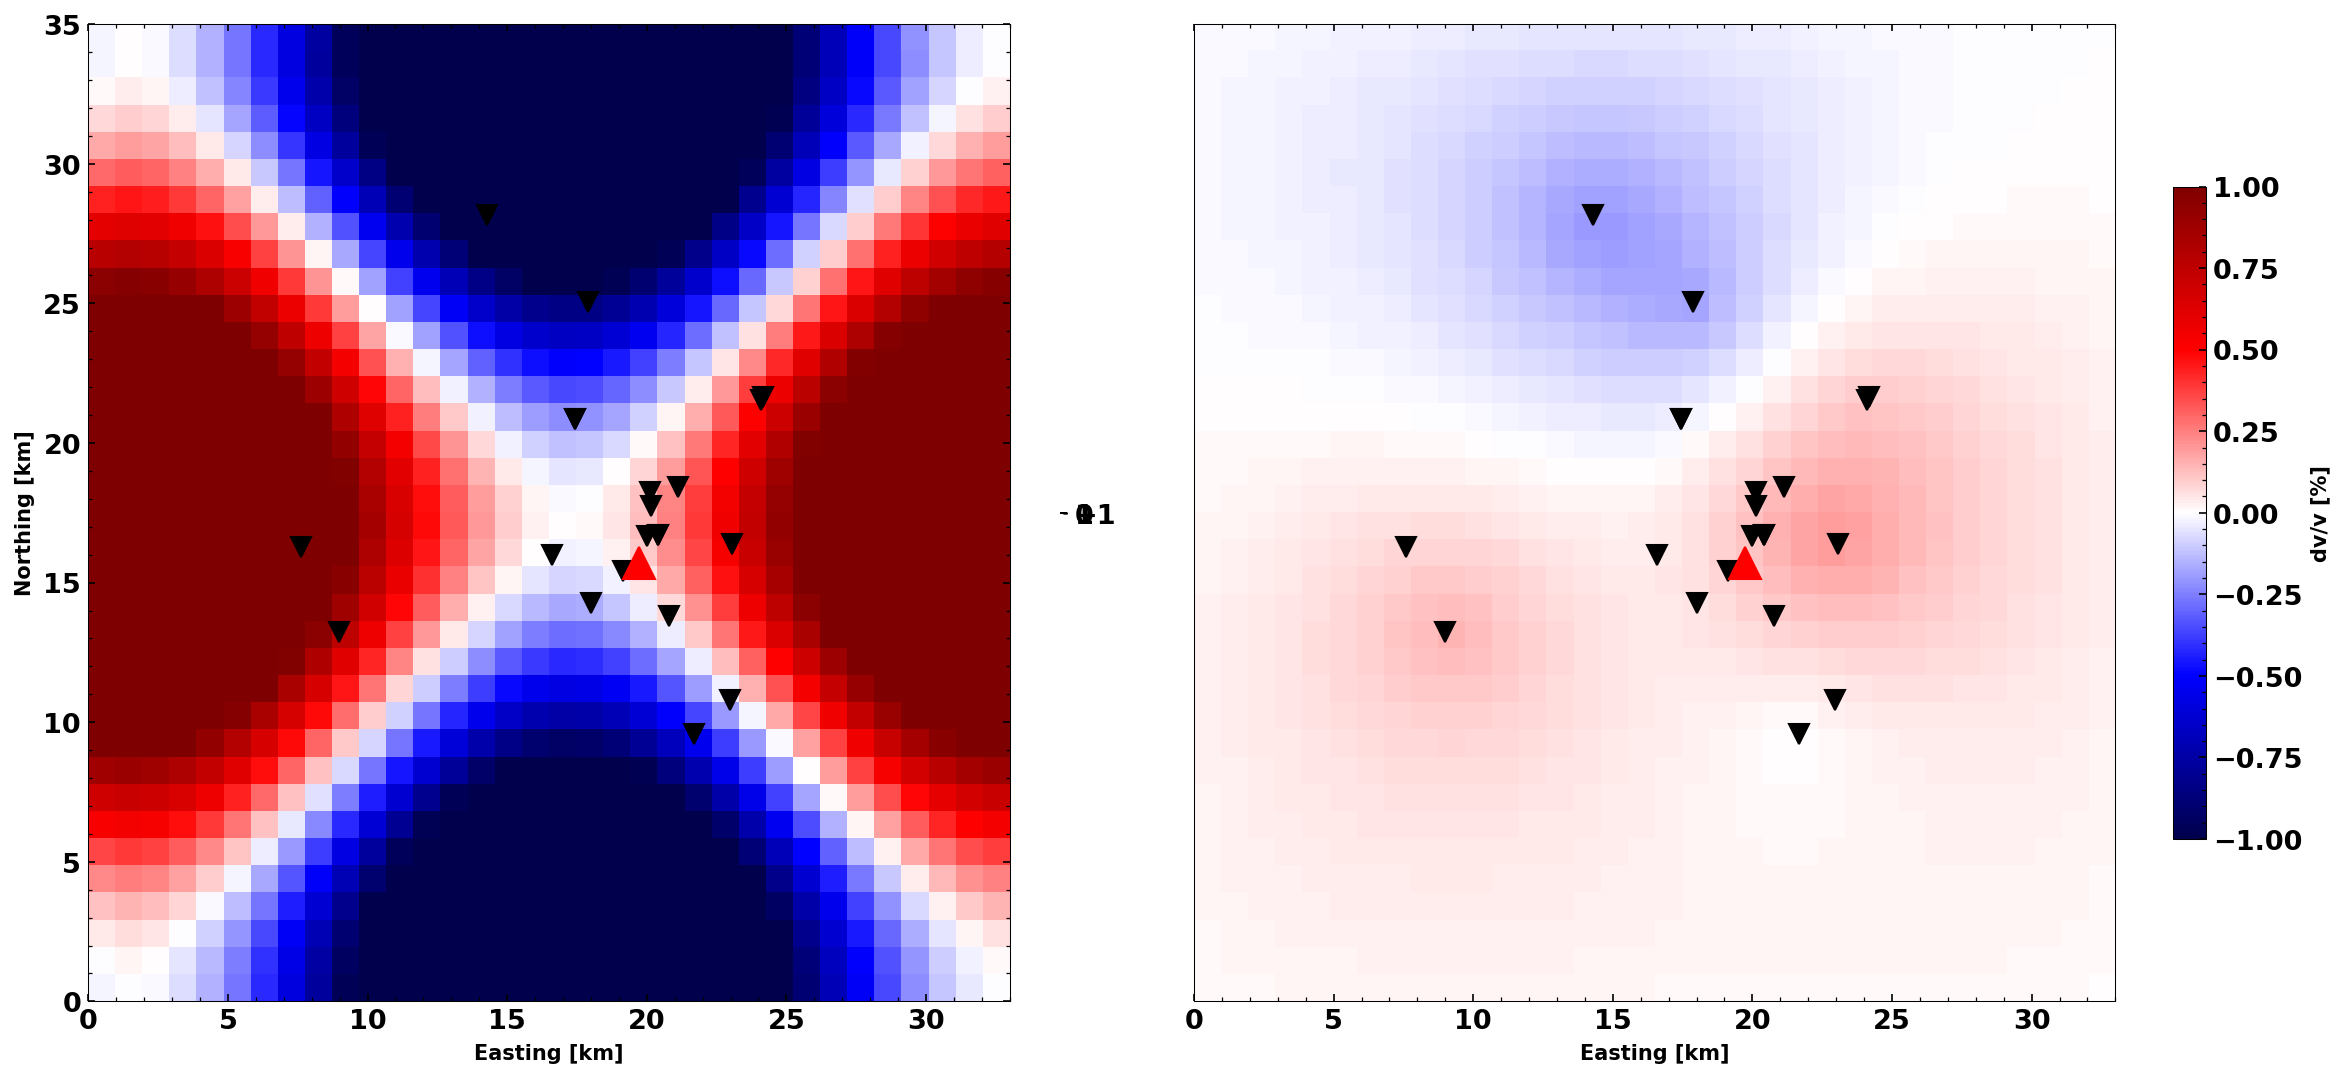

In [31]:
# show synthetic model


from seismic.plot.plot_utils import set_mpl_params
set_mpl_params()

plt.figure(figsize=(16, 9))
plt.subplot(121)
# plt.imshow(-chkb2, cmap='seismic', vmin=-1.5, vmax=1.5, origin='lower', extent=[x[0], x[-1], y[0], y[-1]])
plt.imshow(chkb2, cmap='seismic', vmin=-1, vmax=1, origin='lower', extent=[x[0], x[-1], y[0], y[-1]])

ax0 = plt.gca()
plt.plot(statx, staty, 'kv', ms=10)
plt.plot(msh_x, msh_y, 'r^', ms=15)

# share y-axis with the other plot
plt.ylabel('Northing [km]')
plt.xlabel('Easting [km]')
plt.colorbar(shrink=0.)
# don't show colorbar

plt.subplot(122, sharey=ax0)
plt.imshow(dv[:,:,-4]*-100, cmap='seismic', vmin=-1, vmax=1, origin='lower', extent=[x[0], x[-1], y[0], y[-1]])
plt.plot(statx, staty, 'kv', ms=10)
plt.plot(msh_x, msh_y, 'r^', ms=15)
# don't show y axis
plt.gca().yaxis.set_visible(False)
# both subplots should have the same size
# plt.tight_layout()
plt.colorbar(label='dv/v [%]', shrink=0.5)
plt.xlabel('Easting [km]')
plt.tight_layout()


### plot his publication ready using PyGMT

In [32]:
median_dv = dv[:, :, -4]

In [34]:
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt
from scipy.interpolate import RegularGridInterpolator

dv_total = dv[:,:,-4]

lat0 =  46.05
lon0 = -122.45 # -122.34
lat = km2d(y) + lat0
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
lon = km2lon*(x-x.min())+lon0

region = [lon.min(), lon.max(), lat.min(), lat.max()]

topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region)
# topo is returned as lines are latitude and columns longitude

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data


lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])

f = RegularGridInterpolator((lat, lon), median_dv, bounds_error=False, method='linear')

dv_totalint = f(qcoords)
dv_totalint = dv_totalint.reshape(latqg.shape)

dv_total_grid = DataArray(data=dv_totalint*-100, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -122.022384584 to -122.021666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3647625621 to 46.365


makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


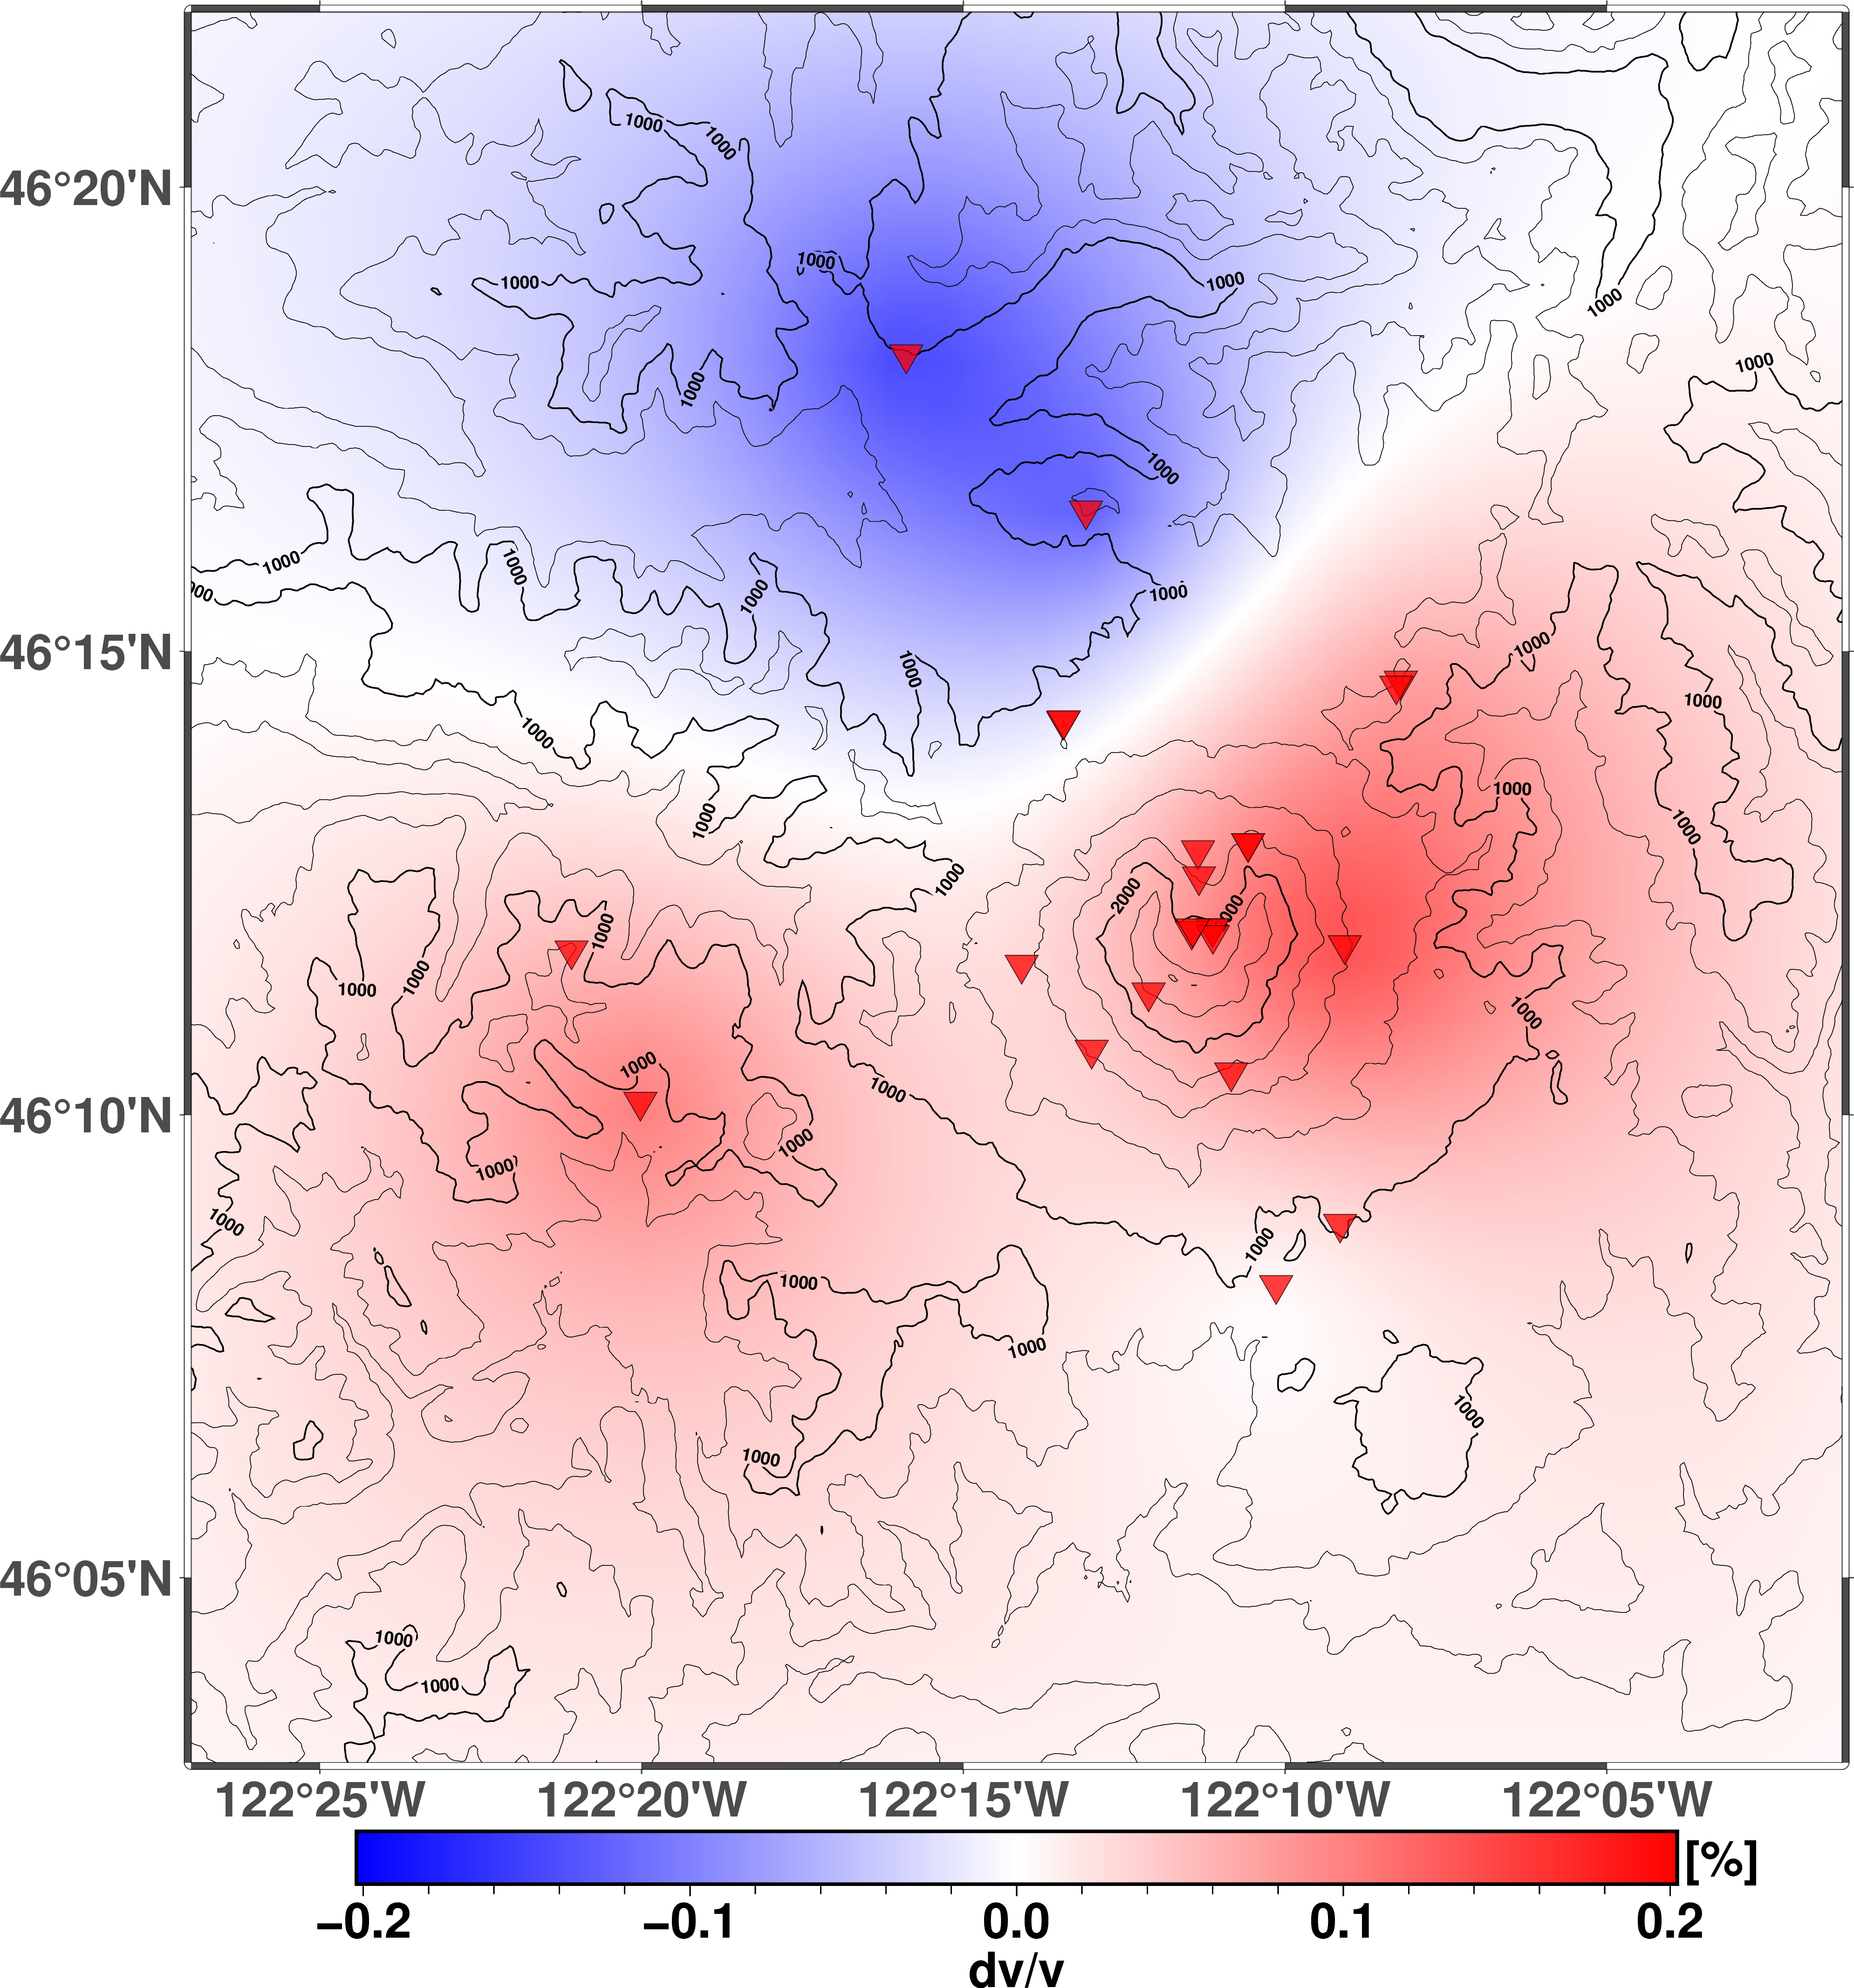

In [35]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
absmax = np.nanmax(abs(dv_total_grid))

persp = [160, 30]
persp = [180, 90]

proj = "M30c"

cb_tick_increment = round(
    (dv_total.max() - dv_total.min())*100/7,
    int(-np.floor(np.log10(100*(dv_total.max() - dv_total.min()))) + 1))

with pygmt.config(
    MAP_FRAME_TYPE='fancy+',
        FONT='25p,Helvetica-Bold'):
    dgrid = pygmt.grdgradient(grid=topo, radiance=[270, 1])
    # add contour lines
    # focus the color scale around 0

    pygmt.makecpt(
        cmap='polar',
        continuous=True,
        reverse=False,
        series=f"{-absmax}/{absmax}",
    )

    fig.grdimage(
        grid=dv_total_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame='a',

        cmap=True,
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,

        transparency=30,
        interpolation='n'
    )
    fig.grdcontour(
        annotation=1000,
        interval=250,
        grid=topo,
    )
    fig.colorbar(frame=["x+ldv/v", "y+l[%]"], projection=proj)
    # add the January 5th, 2024 earthquake
    fig.plot(
        x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, projection=proj)

fig.show()

## plot resolution

In [36]:
# median resolution
medianres = np.nanmedian(resolution, axis=-1)

f = RegularGridInterpolator((lat, lon), medianres, bounds_error=False, method='linear')

resolution_int = f(qcoords)
resolution_int = resolution_int.reshape(latqg.shape)

resolution_grid = DataArray(data=resolution_int, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')

In [37]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
absmax = np.max(abs(dv_total))
persp = [160, 30]
persp = [180, 90]

proj = "M30c"

surftype = 'i'
with pygmt.config(
        MAP_FRAME_TYPE='fancy+', FONT='25p,Helvetica-Bold'):
    dgrid = pygmt.grdgradient(grid=topo, radiance=[270, 1])
    # add contour lines
    pygmt.makecpt(
        cmap='polar',
        continuous=True,
        reverse=False,
        series=f".5/1.5",
        # truncate="/1.5"
    )
    fig.grdimage(
        grid=resolution_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame='a',

        cmap=True,
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        # Sets the height of the three-dimensional relief centimeters
        transparency=30,
        interpolation='n'
    )
    fig.grdcontour(
        annotation=500,
        interval=250,
        grid=topo,
    )

    fig.colorbar(frame=["x+lResolution"], projection=proj)

    fig.plot(
        x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, projection=proj)

fig.show()

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


In [38]:
f = RegularGridInterpolator((lat, lon), chkb2, bounds_error=False, method='linear')

dv_modelint = f(qcoords).reshape(latqg.shape)

dv_model_grid = DataArray(data=dv_modelint, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')

In [39]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
absmax = np.max(abs(dv_total))

persp = [160, 30]
persp = [180, 90]

proj = "M30c"

cb_tick_increment = round(
    (dv_total.max() - dv_total.min())*100/7,
    int(-np.floor(np.log10(100*(dv_total.max() - dv_total.min()))) + 1))

surftype = 'i'
with pygmt.config(
    MAP_FRAME_TYPE='fancy+',
        FONT='25p,Helvetica-Bold'):
    dgrid = pygmt.grdgradient(grid=topo, radiance=[270, 1])
    # add contour lines
    
    fig.grdimage(
        grid=dv_model_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame='a',

        cmap='polar',
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        transparency=30,
        interpolation='n'
    )
    fig.grdcontour(
        annotation=500,
        interval=250,
        grid=topo,
    )

    fig.colorbar(frame=["x+ldv/v", "y+l[%]"], projection=proj)

    fig.plot(
        x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, projection=proj)

fig.show()